In [1]:
import tensorflow as tf
from tensorflow import keras
import ipywidgets

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.12.0


'3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]'

In [ ]:
# ! pip install opencv-python

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports

In [4]:
import os
import io
import matplotlib.pyplot as plt
import cv2
import imageio
#import medmnist
#import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2 as cv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
np.random.seed(SEED)

## Hyperparameters

The hyperparameters are chosen via hyperparameter
search. You can learn more about the process in the "conclusion" section.

In [5]:
#Binray

# DATA
DATASET_NAME = "LAD2000"
BATCH_SIZE = 8
PATH = '/content/gdrive/MyDrive/All_extracted_frames/LAD2000_Vio_Nor/Vio_nor/'
Extraction_Name = ''
# AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (75, 75, 14, 2)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 50

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

# Loading original frames

In [ ]:
! ls '/content/gdrive/MyDrive/All extracted frames/LAD2000_Vio_Nor/Vio_nor/Test'

X_test_dense_flow.npy  X_Test.npy  y_test_dense_flow.npy  y_test.npy


In [ ]:
X_train, y_train = np.load(PATH + 'Train/X_train.npy', mmap_mode = 'r'), np.load(PATH + 'Train/y_train.npy', mmap_mode = 'r')
X_val, y_val = np.load(PATH + 'Val/X_val.npy', mmap_mode = 'r'), np.load(PATH + 'Val/y_val.npy', mmap_mode = 'r')
X_test, y_test = np.load(PATH + 'Test/X_Test.npy', mmap_mode = 'r'), np.load(PATH + 'Test/y_test.npy', mmap_mode = 'r')

In [ ]:
X_train.shape

(4778, 15, 75, 75, 3)

In [ ]:
y_train.shape

(4778,)

In [ ]:
X_test.shape

(1186, 15, 75, 75, 3)

In [ ]:
y_test.shape

(1186,)

In [ ]:
X_val.shape

(1149, 15, 75, 75, 3)

In [ ]:
y_val.shape

(1149,)

In [ ]:
X_train = np.moveaxis(X_train, 1, 3)
X_val = np.moveaxis(X_val, 1, 3)
X_test = np.moveaxis(X_test, 1, 3)

#Loading optical flow

#Loading sparse optical flow

In [ ]:
# X_train_flow, y_train_flow = np.load(PATH + 'Train/X_train_flow.npy'), np.load(PATH + 'Train/y_train_flow.npy')

In [ ]:
# X_train_flow.shape

(4573, 75, 75, 14, 2)

In [ ]:
# y_train_flow.shape

(4573,)

In [ ]:
# X_test_flow, y_test_flow = np.load(PATH + 'Test/X_test_flow.npy'), np.load(PATH + 'Test/y_test_flow.npy')

In [ ]:
# X_test_flow.shape

(1345, 75, 75, 14, 2)

In [ ]:
# y_test_flow.shape

(1345,)

In [ ]:
# X_val_flow, y_val_flow = np.load(PATH + 'Val/X_val_flow.npy'), np.load(PATH + 'Val/y_val_flow.npy')

In [ ]:
# X_val_flow.shape

(655, 75, 75, 14, 2)

In [ ]:
# y_val_flow.shape

(655,)

In [ ]:
# dim = X_val_flow.shape[1:]

In [ ]:
# X_train_flow.shape

(4573, 75, 75, 14, 2)

In [ ]:
# X_val_flow.shape

(655, 75, 75, 14, 2)

In [ ]:
# X_test_flow.shape

(1345, 75, 75, 14, 2)

In [ ]:
# dim

(75, 75, 14, 2)

#Loading dense optical flow

In [6]:
X_train_flow, y_train_flow = np.load(PATH + 'Train/X_train_dense_flow.npy', mmap_mode='r'), np.load(PATH + 'Train/y_train_dense_flow.npy', mmap_mode = 'r')

In [7]:
print(X_train_flow.shape, y_train_flow.shape)

(4778, 75, 75, 14, 2) (4778,)


In [7]:
X_test_flow, y_test_flow = np.load(PATH + 'Test/X_test_dense_flow.npy', mmap_mode='r'), np.load(PATH + 'Test/y_test_dense_flow.npy', mmap_mode = 'r')

In [9]:
print(X_test_flow.shape, y_test_flow.shape)

(1186, 75, 75, 14, 2) (1186,)


In [8]:
X_val_flow, y_val_flow = np.load(PATH + 'Val/X_val_dense_flow.npy', mmap_mode='r'), np.load(PATH + 'Val/y_val_dense_flow.npy', mmap_mode = 'r')

In [11]:
print(X_val_flow.shape, y_val_flow.shape)

(1149, 75, 75, 14, 2) (1149,)


In [12]:
dim = X_val_flow.shape[1:]

In [13]:
dim

(75, 75, 14, 2)

#Binary with MM model


In [14]:
import os
import sys
import cv2
import zipfile
import numpy as np
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import svm
from sklearn.model_selection import train_test_split
# from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from tensorflow.keras import layers, models

In [16]:
model = models.Sequential()
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(32, kernel_size=(3, 3, 1), activation='relu', kernel_initializer='he_uniform', data_format='channels_last', input_shape=dim))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(32, kernel_size=(3, 3, 2), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling3D((3, 3, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(32, kernel_size=(3, 3, 1), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
              metrics=['accuracy'])

history = model.fit(X_train_flow, y_train_flow,
                    batch_size=8,
                    epochs=50,
                    validation_data=(X_val_flow, y_val_flow),
                    shuffle=True)



Epoch 1/50
598/598 [==============================] - 47s 52ms/step - loss: 0.6892 - accuracy: 0.5793 - val_loss: 0.6865 - val_accuracy: 0.5648
Epoch 2/50
598/598 [==============================] - 27s 45ms/step - loss: 0.6533 - accuracy: 0.6151 - val_loss: 0.6880 - val_accuracy: 0.5840
Epoch 3/50
598/598 [==============================] - 26s 44ms/step - loss: 0.6366 - accuracy: 0.6369 - val_loss: 0.7134 - val_accuracy: 0.5614
Epoch 4/50
598/598 [==============================] - 26s 43ms/step - loss: 0.6131 - accuracy: 0.6624 - val_loss: 0.6934 - val_accuracy: 0.5962
Epoch 5/50
598/598 [==============================] - 27s 45ms/step - loss: 0.5968 - accuracy: 0.6781 - val_loss: 0.6897 - val_accuracy: 0.5944
Epoch 6/50
598/598 [==============================] - 27s 45ms/step - loss: 0.5716 - accuracy: 0.6936 - val_loss: 0.7502 - val_accuracy: 0.5640
Epoch 7/50
598/598 [==============================] - 26s 43ms/step - loss: 0.5358 - accuracy: 0.7200 - val_loss: 0.7027 - val_accuracy:

In [24]:
testing_generator = DataGenerator(X_test_flow, y_test_flow)

In [25]:
model.evaluate(testing_generator)

148/148 [==============================] - 3s 14ms/step - loss: 1.2853 - accuracy: 0.6284


[1.285257339477539, 0.6283783912658691]

In [18]:
model.evaluate(X_test_flow, y_test_flow)

38/38 [==============================] - 2s 40ms/step - loss: 1.2835 - accuracy: 0.6290


[1.2835150957107544, 0.6290050745010376]

38/38 [==============================] - 1s 38ms/step


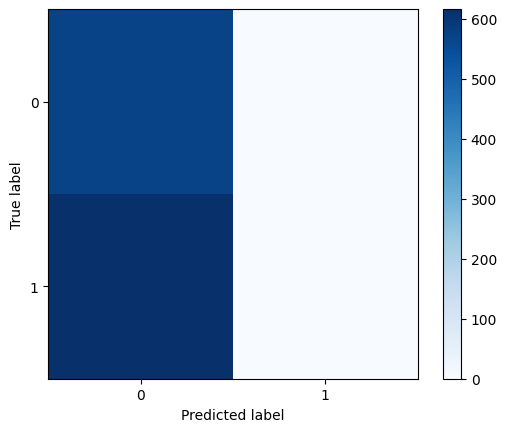

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

classes = [0, 1]
# assuming you have already made predictions and have ground truth labels
y_pred = model.predict(X_test_flow)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test_flow,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#Reducing Model complexity

In [ ]:
# model = models.Sequential()
# model.add(layers.BatchNormalization())
# model.add(layers.Conv3D(32, kernel_size=(3, 3, 1), activation='relu', kernel_initializer='he_uniform', data_format='channels_last', input_shape=dim))
# model.add(layers.MaxPooling3D((2, 2, 1)))
# model.add(layers.BatchNormalization())
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
#               metrics=['accuracy'])

# history = model.fit(X_train_flow, y_train_flow,
#                     batch_size=8,
#                     epochs=50,
#                     validation_data=(X_test_flow, y_test_flow),
#                     shuffle=True)



In [ ]:


# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
#               metrics=['accuracy'])

# history = model.fit(X_val_flow, y_val_flow,
#                     batch_size=8,
#                     epochs=50,
#                     validation_data=(X_test_flow, y_test_flow),
#                     shuffle=True)



In [ ]:
# # Replace "model.h5" with the name of your model file
# model.save('/content/gdrive/MyDrive/Final_models/MM_model_val_test')

### `tf.data` pipeline

In [ ]:
#@title
# import numpy as np
# import cv2
# from tensorflow.keras.utils import Sequence


# class DataGenerator(Sequence):
#     def __init__(self, list_IDs, labels,
#                  to_fit=True, batch_size=BATCH_SIZE, dim=(75, 75, 15),
#                  n_channels=3, n_classes=2, shuffle=True):
#         self.list_IDs = list_IDs
#         self.labels = labels
#         self.to_fit = to_fit
#         self.batch_size = batch_size
#         self.dim = dim
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         """Denotes the number of batches per epoch
#         :return: number of batches per epoch
#         """
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         """Generate one batch of data
#         :param index: index of the batch
#         :return: X and y when fitting. X only when predicting
#         """
#         # Generate indexes of the batch
#         indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X = self._generate_X(list_IDs_temp)

#         if self.to_fit:
#             y = self._generate_y(list_IDs_temp)
#             return X, y
#         else:
#             return X

#     def on_epoch_end(self):
#         """Updates indexes after each epoch
#         """
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def _generate_X(self, list_IDs_temp):
#         """Generates data containing batch_size images
#         :param list_IDs_temp: list of label ids to load
#         :return: batch of images
#         """
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Load RGB image
#             img = cv2.imread(self.image_path + self.labels[ID])
#             # Resize image
#             img = cv2.resize(img, (self.dim[0], self.dim[1]))
#             # Add channel dimension
#             img = np.expand_dims(img, axis=-1)
#             # Store sample
#             X[i,] = img

#         return X

#     def _generate_y(self, list_IDs_temp):
#         """Generates data containing batch_size masks
#         :param list_IDs_temp: list of label ids to load
#         :return: batch if masks
#         """
#         y = np.empty((self.batch_size, *self.dim), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             y[i,] = self._load_grayscale_image(self.mask_path + self.labels[ID])

#         return y
# training_generator = DataGenerator(X_train, y_train)
# validation_generator = DataGenerator(X_val, y_val)

#VIVIT Model

In [9]:
from tensorflow.keras.utils import to_categorical

y_train_flow = to_categorical(y_train_flow, 2)
y_val_flow = to_categorical(y_val_flow, 2)
y_test_flow = to_categorical(y_test_flow, 2)

In [10]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, x_in, y_in, batch_size=BATCH_SIZE, shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = x_in
        self.y = y_in
        self.datalen = len(y_in)
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # get batch indexes from shuffled indexes
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = self.x[batch_indexes]
        y_batch = self.y[batch_indexes]
        return x_batch, y_batch
    
    def __len__(self):
        # Denotes the number of batches per epoch
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

#training_generator = DataGenerator(X_train_flow, y_train_flow)
#validation_generator = DataGenerator(X_val_flow, y_val_flow)

In [11]:

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


In [12]:

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


In [13]:
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/run_lad_flow/checkpoint/'
model_checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

In [14]:
from keras.callbacks import ReduceLROnPlateau
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/run_lad_flow/checkpoint/'
checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

earlystopping = tf.keras.callbacks.EarlyStopping(
                     monitor="val_loss",
                     min_delta=0.025,
                     patience=5,
                     verbose=0,
                     mode="min",
                     baseline=None,
                     restore_best_weights=False
                 )

values = np.linspace(0.00001,LEARNING_RATE,14)[::-1].astype(np.float32)
boundaries = np.linspace(5, 45,13)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)

callbacks = [checkpoint, lr_scheduler, reduce_lr]

In [15]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=2,
):
    input_shape = (75, 75, 14, 2)
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


#Using learning rate scheduler and learning rate reduce on plateau

In [16]:
#new dense optical flow
def run_experiment():
    mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    with mirrored_strategy.scope():
    # Initialize model
        model = create_vivit_classifier(
            tubelet_embedder=TubeletEmbedding(
                embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
            ),
            positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
        )

        # Compile the model with the optimizer, loss function
        # and the metrics.
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

        # Train the model.
        history = model.fit(X_train_flow, y_train_flow, epochs=EPOCHS, validation_data=(X_val_flow, y_val_flow), callbacks=[model_checkpoint, callbacks])

    return model, history


model, history = run_experiment()



Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
150/150 [==============================] - 55s 133ms/step - loss: 0.7281 - accuracy: 0.5251 - val_loss: 0.7156 - val_accuracy: 0.5004 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
150/150 [==============================] - 14s 96ms/step - loss: 0.6764 - accuracy: 0.5737 - val_loss: 0.6891 - val_accuracy: 0.5422 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
150/150 [==============================] - 13s 83ms/step - loss: 0.6786 - accuracy: 0.5615 - val_loss: 0.7090 - val_accuracy: 0.5013 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
150/150 [==============================] - 11s 74ms/step - loss: 0.6820 - accuracy: 0.5576 - val_loss: 0.7061 - val_accuracy: 0.5117 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate t

In [17]:
testing_generator = DataGenerator(X_test_flow, y_test_flow)

In [18]:
model.evaluate(testing_generator)

148/148 [==============================] - 8s 41ms/step - loss: 0.6678 - accuracy: 0.5997


[0.6678218841552734, 0.599662184715271]

38/38 [==============================] - 3s 36ms/step


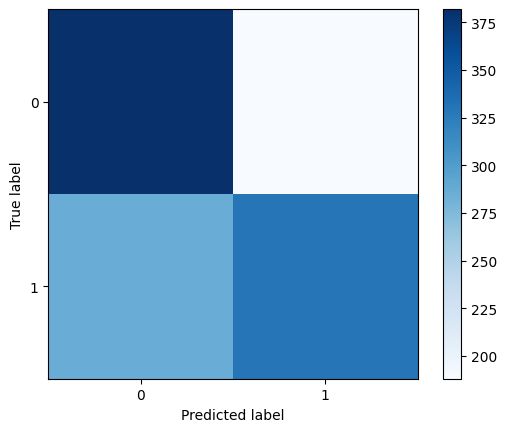

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

classes = [0, 1]
# assuming you have already made predictions and have ground truth labels
y_pred = model.predict(X_test_flow)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test_flow,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [20]:
model.save('/content/gdrive/MyDrive/All_extracted_frames/LAD2000_Vio_Nor/Model_flow')